In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
inflow = pd.read_parquet('/uss/hdsi-prismdata/q1-ucsd-inflows.pqt')
outflow = pd.read_parquet('/uss/hdsi-prismdata/q1-ucsd-outflows.pqt')

# remove rows where memo = category
outflow = outflow[outflow['memo'] != outflow['category']]

outflow_ids = set(outflow["prism_consumer_id"].unique())
inflow_ids = set(inflow["prism_consumer_id"].unique())

in_not_out = inflow_ids - outflow_ids
out_not_in = outflow_ids - inflow_ids

#consumers in both inflow and outflow
consumers_both = sorted(set(inflow["prism_consumer_id"]).intersection(outflow["prism_consumer_id"]))

#80-20 train test split
train_ids, test_ids = train_test_split(consumers_both, test_size=0.2, random_state=42)

inflow_train = inflow[inflow["prism_consumer_id"].isin(train_ids)]
inflow_test  = inflow[inflow["prism_consumer_id"].isin(test_ids)]

outflow_train = outflow[outflow["prism_consumer_id"].isin(train_ids)]
outflow_test  = outflow[outflow["prism_consumer_id"].isin(test_ids)]

# print(f'Inflow_train: {inflow_train["amount"].median()}\nInflow_test: {inflow_test["amount"].median()}\nOutflow_train: {outflow_train["amount"].median()}\nOutflow_test: {outflow_test["amount"].median()}')

In [3]:
outflow_train

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
6,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
7,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
8,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE
...,...,...,...,...,...,...
2595705,5939,acc_9522,PURCHASE 01-14 PUREKANA XXX-XXXXXXX NJ VNT XXXX,116.58,2023-01-17,GENERAL_MERCHANDISE
2595706,5939,acc_9522,PURCHASE 01-18 WAL-MART #XXXX HUTCHINSON KS S...,12.54,2023-01-18,GROCERIES
2595708,5939,acc_9522,PURCHASE 01-27 CLKBANK*MoonReading XXX-XXX-XXX...,11.00,2023-01-27,GENERAL_MERCHANDISE
2595709,5939,acc_9522,PURCHASE 01-26 CASH APP*DIANA STIE XXXXXXXXXX ...,16.00,2023-01-27,GENERAL_MERCHANDISE


## date attributes


In [4]:
outflow_train_add = outflow_train.copy(deep=True)
outflow_train_add['posted_date'] = pd.to_datetime(outflow_train_add['posted_date'])

# day of the week
outflow_train_add['day_of_week'] = outflow_train_add['posted_date'].dt.strftime('%a')

# month
outflow_train_add['month'] = outflow_train_add['posted_date'].dt.month_name()

# quarter
outflow_train_add['quarter'] = outflow_train_add['posted_date'].dt.quarter
q_map = {1: 'q1', 2: 'q2', 3: 'q3', 4: 'q4'}
outflow_train_add['quarter'] = outflow_train_add['quarter'].map(q_map)

# year
outflow_train_add['year'] = outflow_train_add['posted_date'].dt.year

# average time btwn transactions
df = outflow_train_add.copy()
df = df.sort_values(['prism_consumer_id', 'posted_date'])

df['days_since_prev'] = df.groupby('prism_consumer_id')['posted_date'].diff().dt.days.fillna(0)
df['avg_days_between_txn'] = df.groupby('prism_consumer_id')['days_since_prev'].transform('mean')

df = df.sort_index() # Restore original order
outflow_train_add = df

# rolling avg time btwn transactions (window = 5) --> can be helpful for determining financial stability
df = outflow_train_add.sort_values(['prism_consumer_id', 'posted_date']).copy()

df['rolling_avg_days_between_txn'] = (
    df.groupby('prism_consumer_id')['days_since_prev']
      .transform(lambda x: x.rolling(window=5, min_periods=1).mean())
)

outflow_train_add = df.sort_index() # restore to original order

# time since first transaction
df = outflow_train_add.sort_values(['prism_consumer_id', 'posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'])

first_txn = ( # find first transaction date per customer
    df.groupby('prism_consumer_id')['posted_date']
      .transform('min')
)

df['days_since_first_txn'] = (df['posted_date'] - first_txn).dt.days # compute days since first transaction

outflow_train_add = df.sort_index() # restore to original order


## Amount Attributes

In [5]:
# difference from median amount of transactions per month per customer
outflow_train_add['month_med_amnt'] = (outflow_train_add.groupby(['prism_consumer_id', 'year', 'month'])['amount']
                                       .transform('median')
                                      )
outflow_train_add['month_med_amnt_diff'] = outflow_train_add['amount']-outflow_train_add['month_med_amnt']

# Standard deviation of amounts per consumer
group_stats = outflow_train_add.groupby('prism_consumer_id')['amount'].agg(['mean', 'std'])
mean,std = group_stats['mean'],group_stats['std']
outflow_train_add['amnt_zscore'] = (outflow_train_add['amount'] - mean) / std # compute z-score
outflow_train_add['amnt_zscore'] = outflow_train_add['amnt_zscore'].fillna(0) # optional: fill NaN z-scores (e.g. if std = 0 or only one transaction)

# Log-transformed amount --> fix skewness of amounts
outflow_train_add['log_amnt'] = np.log1p(outflow_train_add['amount'])

In [6]:
outflow_train_add

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,day_of_week,month,quarter,year,days_since_prev,avg_days_between_txn,rolling_avg_days_between_txn,days_since_first_txn,month_med_amnt,month_med_amnt_diff,amnt_zscore,log_amnt
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES,Mon,September,q3,2022,3.0,1.100917,1.0,224,22.66,-4.24,-0.705843,2.966303
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES,Mon,September,q3,2022,6.0,1.100917,1.2,210,22.66,3.81,-0.288038,3.313095
6,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE,Mon,April,q2,2022,3.0,1.100917,1.4,63,26.68,-14.95,0.000000,2.543961
7,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES,Wed,March,q1,2022,1.0,1.100917,0.4,23,26.19,3.85,-0.328565,3.435277
8,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE,Tue,March,q1,2022,1.0,1.100917,1.0,43,26.19,-22.03,0.000000,1.640937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595705,5939,acc_9522,PURCHASE 01-14 PUREKANA XXX-XXXXXXX NJ VNT XXXX,116.58,2023-01-17,GENERAL_MERCHANDISE,Tue,January,q1,2023,8.0,2.002770,5.8,713,19.48,97.10,0.000000,4.767119
2595706,5939,acc_9522,PURCHASE 01-18 WAL-MART #XXXX HUTCHINSON KS S...,12.54,2023-01-18,GROCERIES,Wed,January,q1,2023,1.0,2.002770,5.4,714,19.48,-6.94,0.000000,2.605648
2595708,5939,acc_9522,PURCHASE 01-27 CLKBANK*MoonReading XXX-XXX-XXX...,11.00,2023-01-27,GENERAL_MERCHANDISE,Fri,January,q1,2023,9.0,2.002770,4.8,723,19.48,-8.48,0.000000,2.484907
2595709,5939,acc_9522,PURCHASE 01-26 CASH APP*DIANA STIE XXXXXXXXXX ...,16.00,2023-01-27,GENERAL_MERCHANDISE,Fri,January,q1,2023,0.0,2.002770,4.8,723,19.48,-3.48,0.000000,2.833213


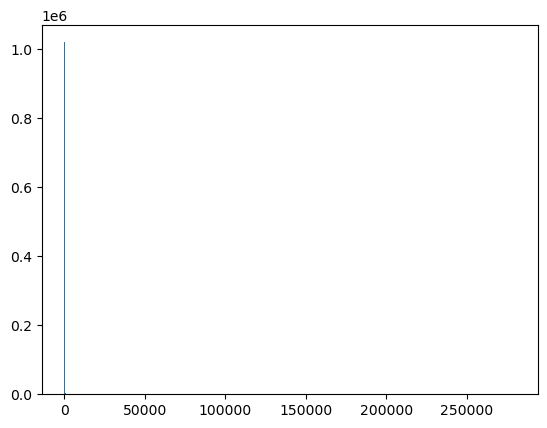

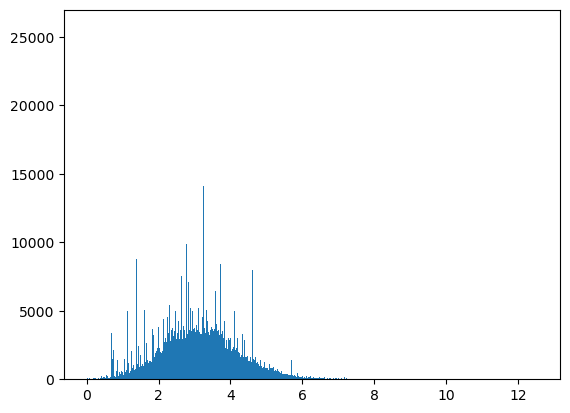

In [7]:
import matplotlib.pyplot as plt
plt.hist(outflow_train_add['amount'], bins = 1000)
plt.show()
plt.hist(outflow_train_add['log_amnt'], bins = 1000)
plt.show()